In [5]:
from sklearn.metrics import f1_score
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

from torch.utils.data import TensorDataset, DataLoader

In [6]:
# Load Data
train_data = np.load('train_split.npy', allow_pickle=True).item()
val_data = np.load('val_split.npy', allow_pickle=True).item()

In [7]:
# Understand the dataset
Frames = 10
MOUSE = 2
DATA_POINT = 7

vocab = train_data['vocabulary']
sequences = train_data['sequences']

# One video clip.
sample_key = list(sequences.keys())[0]
sample_sequence = sequences[sample_key]

keypoints = sample_sequence['keypoints'] # shape: (frame, 2, 2, 7)
annotations = sample_sequence['annotations'] # shape: (frame,)

print(f"Sequence {sample_key} has {sample_sequence['keypoints'].shape[0]} frames")

flattened_data = []

for t in range (Frames):
  for mouse in range (MOUSE):
    for point in range (DATA_POINT):
      x = keypoints[t, mouse, 0, point]
      y = keypoints[t, mouse, 1, point]
      flattened_data.append({'frame': t,
                'mouse': mouse,
                'keypoint_id': point,
                'x': x,
                'y': y,
                'annotation': annotations[t]})

df = pd.DataFrame(flattened_data)

print(df.head(20))

Sequence 283a94cc8e has 1283 frames
    frame  mouse  keypoint_id           x           y  annotation
0       0      0            0  892.454358  426.636570           0
1       0      0            1  830.454358  429.636570           0
2       0      0            2  860.454358  380.636570           0
3       0      0            3  826.454358  397.636570           0
4       0      0            4  711.454358  329.636570           0
5       0      0            5  784.454358  293.636570           0
6       0      0            6  726.454358  265.636570           0
7       0      1            0  790.971381  489.302090           0
8       0      1            1  857.971381  476.302090           0
9       0      1            2  842.971381  532.302090           0
10      0      1            3  867.971381  503.302090           0
11      0      1            4  875.971381  433.302090           0
12      0      1            5  901.971381  481.302090           0
13      0      1            6  916.97138

In [8]:
train_data

{'vocabulary': {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3},
 'sequences': {'283a94cc8e': {'keypoints': array([[[[892.45435791, 830.45435791, 860.45435791, ..., 711.45435791,
             784.45435791, 726.45435791],
            [426.63657016, 429.63657016, 380.63657016, ..., 329.63657016,
             293.63657016, 265.63657016]],
   
           [[790.97138062, 857.97138062, 842.97138062, ..., 875.97138062,
             901.97138062, 916.97138062],
            [489.30209017, 476.30209017, 532.30209017, ..., 433.30209017,
             481.30209017, 425.30209017]]],
   
   
          [[[900.73253174, 838.73253174, 875.73253174, ..., 737.73253174,
             791.73253174, 729.73253174],
            [429.24211472, 430.24211472, 385.24211472, ..., 338.24211472,
             288.24211472, 276.24211472]],
   
           [[810.63255005, 866.63255005, 836.63255005, ..., 891.63255005,
             887.63255005, 911.63255005],
            [463.21897817, 480.21897817, 531.21897817,

In [9]:
train_data['sequences'].keys()

dict_keys(['283a94cc8e', '24d04a0320', '9212f26324', 'bf702e3c78', 'e85486f7ea', '97b56c159b', '6b1df151b9', 'f5c7687579', '70fbc2c277', '83bf0c4244', '0f7327e2c8', 'fc572dab52', '677b9abbc8', 'ecdd2509b3', 'bb97f42a1b', '6b6b0b3ead', 'e2cd67e1a3', '0f38732507', 'ff478456a9', '8f6193714b', 'f06c359e8f', '7053f4a2d0', '0b278ffe3d', 'ed0e470aea', '98f42f62ec', '5490af36aa', 'cd5fbeaa98', '58e6d37468', '18cd199663', 'af86182e32', '527dbf1279', 'ecbeca2d0e', '8331b66dc4', '61caaf5764', 'a4c03eaf9d', '747858dc95', 'eac63ca45e', '1387d17de0', '4aa2e49a0b', '2070ae2860', 'a908230f0e', '9067e84eb9', 'e3b5115e7b', '0d7c7eb4b2', '22f1628272', '4ce1975da0', 'd1d1da0f45', '30b97085a2', '5587e73462', '736d6f564a', 'b62aff1dc4', 'b40d39ca72', 'e2d0f167da', '1fed911c1c', 'df1728596d', '3b9324f65c', 'f34ed34319', '99e98c7b00', '1cac195d39', 'f45694e6b9'])

In [10]:
train_data['sequences']['283a94cc8e']['keypoints'].shape

(1283, 2, 2, 7)

In [11]:
# This sequence/vedio clip has 1283 frames.
train_data['sequences']['283a94cc8e']['keypoints'].shape[0]

1283

In [12]:
class FC_classifier(nn.Module):
    def __init__(self, input_dim):
        super(FC_classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [13]:
# train data processing
train_features = []
train_labels = []

for sequence in train_data['sequences'].values():
    keypoints = sequence['keypoints']
    annotations = sequence['annotations']

    num_frames = keypoints.shape[0]
    # Flatten features from (frames, 2 mice , 2 xy , 7 keypoints) into (frames, 28)
    features_flat = keypoints.reshape(num_frames, -1)

    train_features.append(features_flat)
    train_labels.append(annotations)

# concatenate all vedio (sequences)
train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)


print(train_features.shape)
print(train_labels.shape)


(426635, 28)
(426635,)


In [14]:
# validation data processing
val_features = []
val_labels = []

for sequence in val_data['sequences'].values():
    keypoints = sequence['keypoints']
    annotations = sequence['annotations']

    num_frames = keypoints.shape[0]
    features_flat = keypoints.reshape(num_frames, -1)

    val_features.append(features_flat)
    val_labels.append(annotations)

val_features = np.concatenate(val_features, axis=0)
val_labels = np.concatenate(val_labels, axis=0)


print(val_features.shape)
print(val_labels.shape)

(81103, 28)
(81103,)


In [15]:
def label_weight(labels):
    unique, counts = np.unique(labels, return_counts=True)
    weight = len(labels) / (counts * len(unique))
    return torch.tensor(weight, dtype=torch.float32)

weight = label_weight(train_labels)
print(weight)

tensor([7.7485, 0.8923, 4.6293, 0.3946])


In [16]:
def validation(model, val_features, val_labels, device='cuda' if torch.cuda.is_available() else 'cpu'):
    X = torch.tensor(val_features, dtype=torch.float32)
    y = torch.tensor(val_labels, dtype=torch.long)

    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    model = model.to(device)
    model.eval()

    total_predictions = 0
    correct_predictions = 0
    labels = []
    total_predicted = []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            batch_X = batch_X.view(batch_X.size(0), -1)
            outputs = model(batch_X)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += batch_y.size(0)
            correct_predictions += (predicted == batch_y).sum().item()
            labels = labels + batch_y.tolist()
            total_predicted = total_predicted + predicted.tolist()
            #label = ['attack', 'investigation', 'mount', 'other']

    accuracy = 100 * correct_predictions / total_predictions
    F1 = f1_score(labels, total_predicted, average='macro', labels=[0, 1, 2])
    print(f"Val-F1: {F1:.4f}")
    return accuracy, F1

In [17]:
def train_model(model, train_features, train_labels, epochs=10, batch_size=256, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    X = torch.tensor(train_features, dtype=torch.float32)
    y = torch.tensor(train_labels, dtype=torch.long)

    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # weight = label_weight(train_labels)
    weight = torch.tensor([1, 1, 1, 1], dtype=torch.float32)
    criterion = torch.nn.CrossEntropyLoss(weight=weight)

    train_accuracies = []
    train_f1s = []
    val_accuracies = []
    val_f1s = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_predictions = 0
        correct_predictions = 0
        labels = []
        total_predicted = []
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            batch_X = batch_X.view(batch_X.size(0), -1) # (batch_size, 28) , 28 features;
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += batch_y.size(0)
            correct_predictions += (predicted == batch_y).sum().item()
            total_loss += loss.item() * batch_X.size(0)
            labels = labels + batch_y.tolist()
            total_predicted = total_predicted + predicted.tolist()

        avg_loss = total_loss / len(dataset)
        accuracy = 100 * correct_predictions / total_predictions
        F1 = f1_score(labels, total_predicted, average='macro', labels=[0, 1, 2])
        print(f"Epoch {epoch+1}/{epochs} - Train-Loss: {avg_loss:.4f} - Train-Accuracy: {accuracy:.2f}% - Train-F1: {F1:.4f}")
        train_accuracies.append(accuracy)
        train_f1s.append(F1)

        val_accuracy,val_f1= validation(model, val_features, val_labels, device='cuda' if torch.cuda.is_available() else 'cpu')
        val_accuracies.append(val_accuracy)
        val_f1s.append(val_f1)
    print("Training complete.")
    return model, train_accuracies, train_f1s, val_accuracies, val_f1s

In [18]:
input_dim = 28
model = FC_classifier(input_dim=input_dim)
model, train_accuracies, train_f1s, val_accuracies, val_f1s = train_model(model, train_features, train_labels, epochs=30, batch_size=256, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu')

Epoch 1/30 - Train-Loss: 0.4480 - Train-Accuracy: 84.24% - Train-F1: 0.4838
Val-F1: 0.4435
Epoch 2/30 - Train-Loss: 0.3680 - Train-Accuracy: 86.87% - Train-F1: 0.5380
Val-F1: 0.5277
Epoch 3/30 - Train-Loss: 0.3502 - Train-Accuracy: 87.47% - Train-F1: 0.5548
Val-F1: 0.5576
Epoch 4/30 - Train-Loss: 0.3406 - Train-Accuracy: 87.77% - Train-F1: 0.5665
Val-F1: 0.5074
Epoch 5/30 - Train-Loss: 0.3307 - Train-Accuracy: 88.13% - Train-F1: 0.5839
Val-F1: 0.5351
Epoch 6/30 - Train-Loss: 0.3233 - Train-Accuracy: 88.37% - Train-F1: 0.5957
Val-F1: 0.5446
Epoch 7/30 - Train-Loss: 0.3164 - Train-Accuracy: 88.58% - Train-F1: 0.6072
Val-F1: 0.5373
Epoch 8/30 - Train-Loss: 0.3109 - Train-Accuracy: 88.78% - Train-F1: 0.6195
Val-F1: 0.5270
Epoch 9/30 - Train-Loss: 0.3061 - Train-Accuracy: 88.94% - Train-F1: 0.6272
Val-F1: 0.5293
Epoch 10/30 - Train-Loss: 0.3023 - Train-Accuracy: 89.08% - Train-F1: 0.6359
Val-F1: 0.5365
Epoch 11/30 - Train-Loss: 0.2987 - Train-Accuracy: 89.21% - Train-F1: 0.6418
Val-F1: 0.53

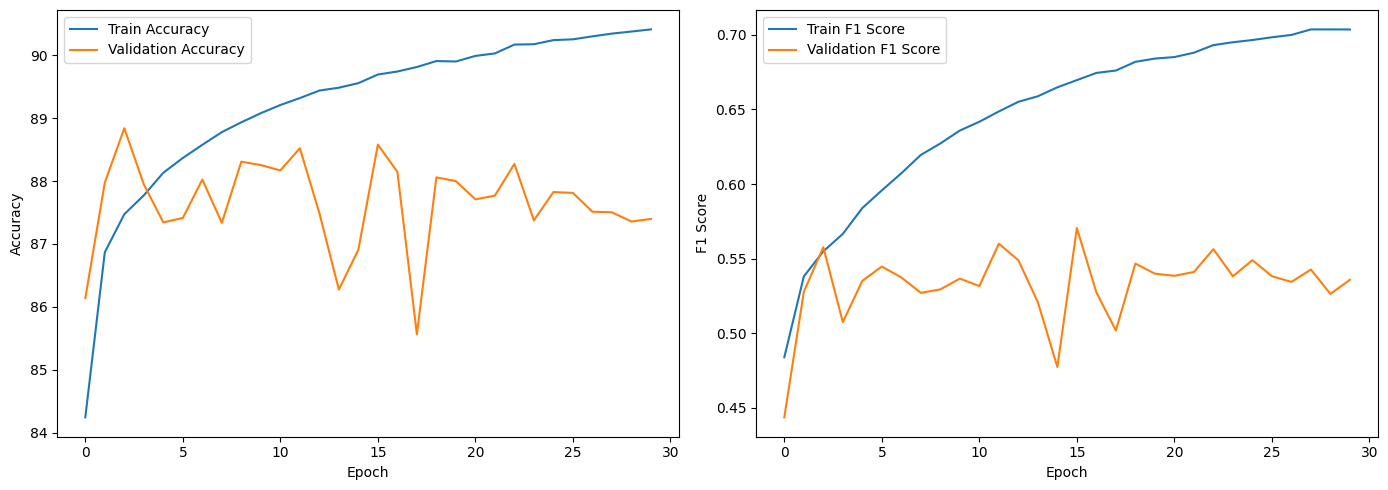

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Train F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()